In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np

bp 275800
80624.65 seconds
14253.408134156905 7.015865893881179e-05 ../log/thundering-barracuda_ef4afaf1-8487-488b-b199-53aa8c791c98.jsonl


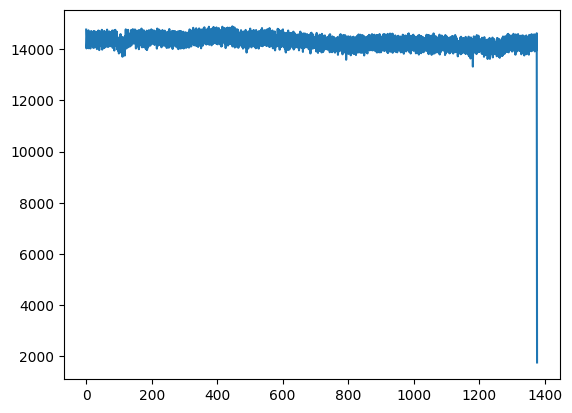

In [2]:
filenames = [
    # '../log/covering-deductible-frame-local_0408e05c-2262-473b-a19d-e3d247cc493e.jsonl',
    # '../log/corn-template-normal-s3_ec81d834-2b97-4df2-bb31-5c5579eb5417.jsonl',
    # '../log/beige-pint-mouth-noop_048141ea-c6cc-4e06-929f-acebf0fe4f30.jsonl',
    # '../log/espressivo-factorial-state-s3_threaded_1103ee48-4427-480c-abad-49db1e262c87.jsonl',
    # '../log/absolute-tuba-configuration-768_412a198c-fdd6-4637-9aa8-0ba5b3c5cd13.jsonl',
    # '../log/damp-fort-guard-1024_a238ec83-2dbb-4667-ab1e-8a6accd1fd2a.jsonl',
    # '../log/patient-rabbit-768-noop_b3aaf332-8a0c-4e5b-a7dd-926849007bbb.jsonl',
    # '../log/brilliant-function-1024-noop_3a84947d-3e75-4438-8fde-5009966f26fb.jsonl',
    # '../log/thick-meter-768-s3_threaded_3417f6d8-c38d-49f8-ab0c-75e13d7e5d46.jsonl',
    # '../log/isobaric-newton-1024-s3_threaded_b385e53d-9f7c-4237-a4e1-28f857d16d0c.jsonl',
    # '../log/figurative-trim-768-noop_e8dee59c-ced0-43e2-980c-c6f5df3e6e7f.jsonl',
    # '../log/strong-valance-1024-noop_ebee7e09-979f-44d5-aa59-3862ff1a050e.jsonl',
    # '../log/woolen-margin-768-s3_threaded_65720572-4641-4417-bb21-36b18fc3876f.jsonl',
    # '../log/vertical-pita-1024-s3_threaded_859c8af6-222b-4e6e-8c93-a4c7315d942f.jsonl',
    # '../log/merry-quanta-512-noop-16_412b5764-e636-4b01-a5ea-91fab64a7389.jsonl',
    # '../log/full-pagoda-512-noop-8_1817daa8-d99d-4c82-b941-1879fe2636a4.jsonl',    
    # '../log/humble-automaton-512-s3_threaded-8_f45205e2-e64d-443c-a6dd-be7d18d44e9c.jsonl',
    # '../log/greasy-grout-512-s3_threaded-16_5f5def98-2d6e-4fae-962f-fd8c58b0d8fb.jsonl',
    '../log/thundering-barracuda_ef4afaf1-8487-488b-b199-53aa8c791c98.jsonl',
    # '../log/reduced-kudzu_9ec0aa5f-2b79-4c3f-8cc9-6e11c9547afe.jsonl'
]

for filename in filenames:
    data = []
    with open(filename) as f:
        # read all lines of the jsonl file
        lines = f.readlines()
        # parse each line as json
        for line in lines:
            data.append(json.loads(line))

    batches = [d for d in data if d['event'] == 'batch_processed']
    
    print('bp', batches[-1]['batches_processed'])

    total_elapsed = data[-1]['timestamp'] - data[0]['timestamp']

    print(round(total_elapsed, 2), 'seconds')

    sps = [d['samples_per_second'] for d in batches if 'samples_per_second' in d]
    plt.plot(sps, label=filename)
    print(np.mean(sps), 1/np.mean(sps), filename)

    usages = [d for d in data if d['event'] == 'system_usage']

    # plt.plot([u['torch.cuda.memory_allocated'] for u in usages])
    # plt.plot([u['torch.cuda.memory_reserved'] for u in usages])


# plt.legend()

    


In [5]:
batches[1].keys()

dict_keys(['event', 'batches_processed', 'activation_shape', 'activations_mean', 'activations_min', 'activations_max', 'activations_std', 'sample_mean_activations', 'sample_max_activations', 'sample_min_activations', 'sample_attention_mask', 'attention_mask_shape', 'attention_mask_sum', 'sample_plaintext', 'seconds_since_last_log', 'samples_per_second', 'timestamp', 'hr_timestamp'])

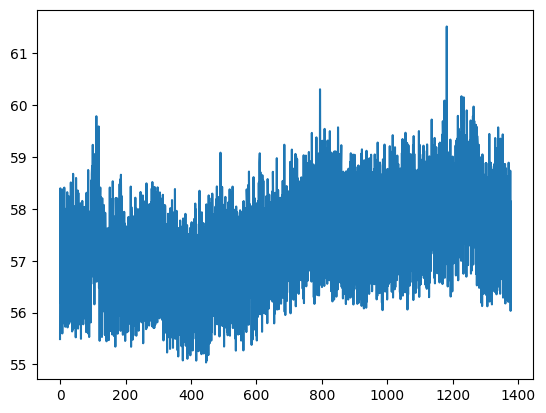

In [6]:
sps = [d['seconds_since_last_log'] for d in batches if 'seconds_since_last_log' in d]
plt.plot(sps, label=filename)

In [14]:
1_197_252_000 / 4

299313000.0

In [ ]:
60*1400 * 14253

In [13]:
60*1400 / 60 / 60 / 4

5.833333333333333

In [14]:
filenames = [
    '../log/thundering-barracuda_953b1120-4f81-4b8f-a177-9e2870e6fde2.jsonl'
]

data = []
with open(filenames[0]) as f:
    # read all lines of the jsonl file
    lines = f.readlines()
    # parse each line as json
    for line in lines:
        data.append(json.loads(line))

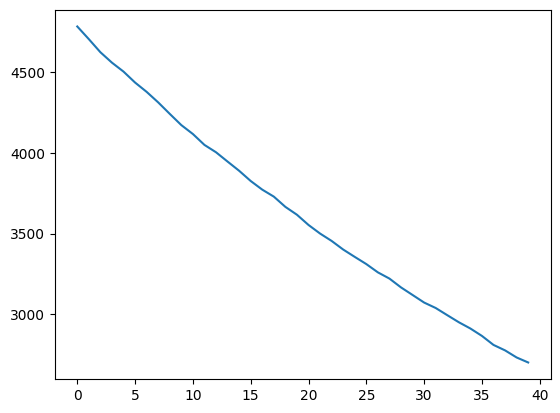

In [15]:
plt.plot([d['rmse'] for d in data])

In [23]:
for b in batches:

    if 'endof' in b['sample_plaintext']:
        print(b['sample_plaintext'])

 20,000 people in Manchester in February 1988. Section 28 caused real problems for people in their workplaces and schools due to self censorship. The law was finally repealed in 2003.<|endoftext|>Joe Robbins/Getty Images

Terrell Owens has been out of the NFL long enough to attain eligibility for the Pro Football Hall of Fame
 that it will lead to a range of new services. In fact, it may mean a host of yet unknown services that will deliver real value to consumers and society more generally.”<|endoftext|>Breaking News Emails Get breaking news alerts and special reports. The news and stories that matter, delivered weekday mornings.

July 22
 the authentic orange paint job is a little too garish for you, check out the original and (equally illustrious) Nakajima racer, a lovely blue R90/6. Is there a better custom BMW builder in the world today?<|endoftext|>Ikuze shining running forever!

Mae e tsu
<|endoftext|>whatfreshhellisthis-deactivated answered:

Put down the Nietzsche and stop bei

In [3]:
f"{1892800 * 512:,}"

'969,113,600'

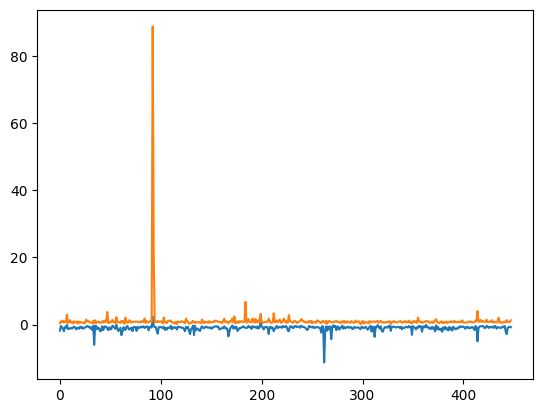

In [21]:
plt.plot(data[0]['sample_min_activations'])
plt.plot(data[0]['sample_max_activations'])



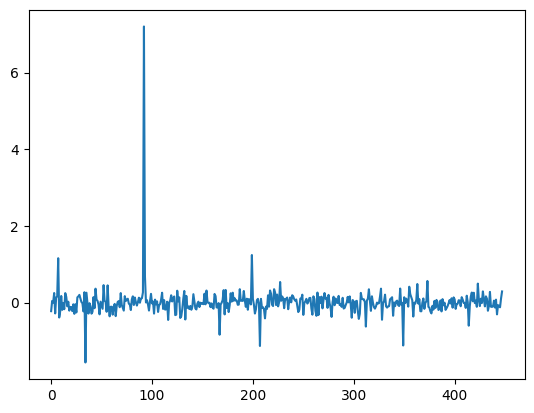

In [16]:
plt.plot(data[0]['sample_mean_activations'])

In [7]:
import torch

In [8]:
d = torch.load('../cache/00a0deec-3379-45f0-988a-ae1e483658a6.saved.pt')

/tmp/ipykernel_108756/1127678546.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load('../cache/00a0deec-3379-45f0-988a-ae1e483658a6.saved.pt')


In [9]:
d.shape

torch.Size([1024, 512, 1536])